This notebook was written by Alejandro Montañez-Barrera [@alejomonbar](https://github.com/alejomonbar).

# The Bin Packing problem 

The [bin packing problem](https://en.wikipedia.org/wiki/Bin_packing_problem) is an optimization problem where given a number of items with an assigned weight, we look at the best way to group the items minimizing the number of bins or containers needed to store them. The restriction, in this case, is the capacity of the bins which cannot surpass a certain weight. This problem has many real applications in areas such as loading trucks with a weight restriction, filling up containers, and FPGA semiconductors chip design. 

In terms of complexity, the bin packing problem is an NP-hard problem. However, there are efficient algorithms that allow the arrangement of a large number of items. One of them is the first fit, which provides a fast but not optimal solution to the problem. 

For our problem, we will explore the solution to the bin packing problem, using a quantum computing representation in terms of quadratic unconstraint binary optimization (QUBO) and using the quantum approximation optimization (QAOA) algorithm. 

### Problem statement

$$\begin{equation}
\min \sum_{j=0}^{m-1} y_j\tag{1},
\end{equation}$$

subject to the following constraints. Each bin's weight capacity should not be exceeded

$$\begin{equation}
\sum_{i=0}^{n-1} w_i x_{ij} \le B y_j \quad \forall j=0,...,m-1\tag{2},
\end{equation}$$

and each item can only be assigned to one bin

$$\begin{equation}
\sum_{j=0}^{m-1} x_{ij} = 1 \quad \forall i = 0, ..., n-1.\tag{3}
\end{equation}$$

Binary variables indicating item-bin assignments and bin utilization

$$\begin{equation}
x_{ij} \in {0,1} \quad \forall i=0,..,n-1 \quad \forall j=0,..,m-1,\tag{4}
\end{equation}$$

$$\begin{equation}
y_j \in {0,1} \quad \forall j=0,..,m-1\tag{5}
\end{equation}$$

In the above equations, $n$ represents the number of items (nodes), $m$ represents the number of bins, $w_{i}$ is the weight of the $i$-th item, $B$ denotes the maximum weight capacity of each bin, and $x_{ij}$ and $y_j$ are binary variables representing the presence of item $i$ in bin $j$ and the utilization of bin $j$, respectively. The objective function in Eq.(1) aims to minimize the number of bins used, while Eq.(2) enforces the constraint on bin weight capacity. Eq.(3) ensures that each item is assigned to only one bin, and Eqs.(4) and (5) define the binary nature of variables $x_{ij}$ and $y_j$.

In [1]:
# Import external libraries
from openqaoa.problems import BinPacking
from openqaoa.problems import FromDocplex2IsingModel
from openqaoa import QAOA, QUBO
import numpy as np
import matplotlib.pyplot as plt

font_size = 16
plt.rcParams['font.size'] = font_size

%matplotlib inline

## Setting the problem

It generates the data necessary to create the BinPacking problem, i.e. to consider number of items, maximum number of bins, max weight of a bin, and the weight of each item.

In [2]:
np.random.seed(1234)
#setting the problem
n_items = 3 # number of items
n_bins = 2 # maximum number of bins the solution will be explored on 
min_weight = 1 # minimum weight of the items
max_weight = 3 # maximum weight of the items
weight_capacity = 5 # weight capacity of the bins
weights = np.random.randint(min_weight, max_weight, n_items) # random instance of the problem

## Classical solution and visualizaiton using CPLEX
This solution is based on the python based library of `CPLEX`, [docplex](https://pypi.org/project/docplex/).

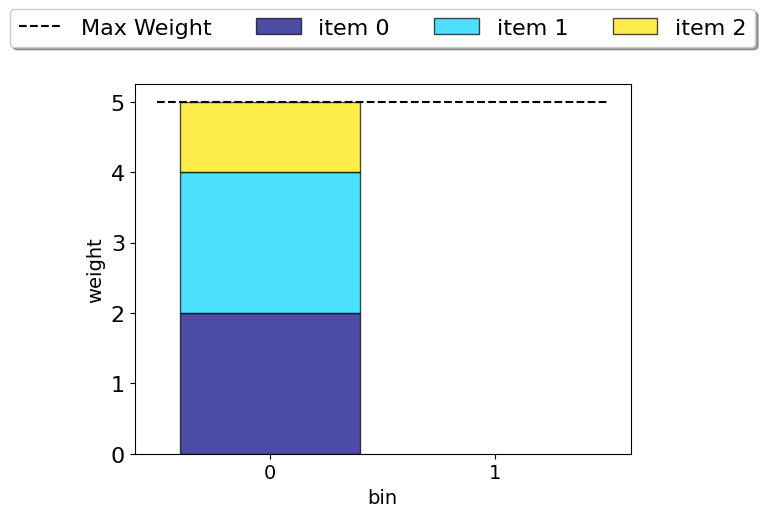

In [3]:
bpp = BinPacking(weights, weight_capacity, n_bins=n_bins, simplifications=False) #setting the problem using a openqaoa class
sol_cplex = bpp.classical_solution(string=True) # getting the optimal solution using DocPLEX 
fig, ax = plt.subplots()
fig, ax = bpp.plot_solution(sol_cplex, ax)# Plotting the optimal solution

## Solving using QAOA

We define a convenience function to solve the problem using QAOA, the steps abstracted here are:

* Setting the problem up and normalizing the weights
* Defining the QAOA properties, including parameter initialization, classical optimizer, etc...
* Compilation of the QAOA object
* Optimization

In [4]:
def qaoa_result(qubo, p=5, maxiter=100):
    """
    qubo (openqaoa.QUBO): Ising Hamiltonian of the problem
    p (int): Number of layers of the QAOA circuit
    maxiter (int): Maximum number of iterations
    """
    max_weight = np.max(qubo.weights)
    qubo_weights = [w/max_weight for w in qubo.weights]
    qubo_normal = QUBO(qubo.n, qubo.terms, qubo_weights) # Normalizing the QUBO weights, (it can help sometimes to improve the results)

    qaoa = QAOA()
    qaoa.set_circuit_properties(p=p, init_type="ramp", linear_ramp_time=0.1) # initialization betas and gammas with a ramp technique
    qaoa.set_classical_optimizer(maxiter=maxiter) 
    qaoa.compile(qubo_normal)
    qaoa.optimize()
    return qaoa

### 1 - Solve using slack variable encoding

In [5]:
penalty = [10, 10] # [Equality, Inequality] constraints
bpp_slack = BinPacking(weights, weight_capacity, n_bins=n_bins, penalty=penalty, simplifications=False, method="slack")
qubo = bpp_slack.qubo # Ising Hamiltonian of the BPP using the slack variables encoding 
results_slack = qaoa_result(qubo, p=5, maxiter=100)

We can now analyze the solution generated by the QAOA optimization and visualize the result and cost

In [6]:
nstates = 10
results = results_slack.result.lowest_cost_bitstrings(nstates)
idx_opt = 0
p = 0
for n in range(nstates): # There are multiple optimal solutions, 
    # Let's check which states share the same enegry with the ground state
    if results["bitstrings_energies"][n] == results["bitstrings_energies"][idx_opt]:
        p += results["probabilities"][n]
print(f"The probability of finding the optimal solution using the slack approach is: {round(100*p,1)}%")

The probability of finding the optimal solution using the slack approach is: 0.2%


states kept: 10


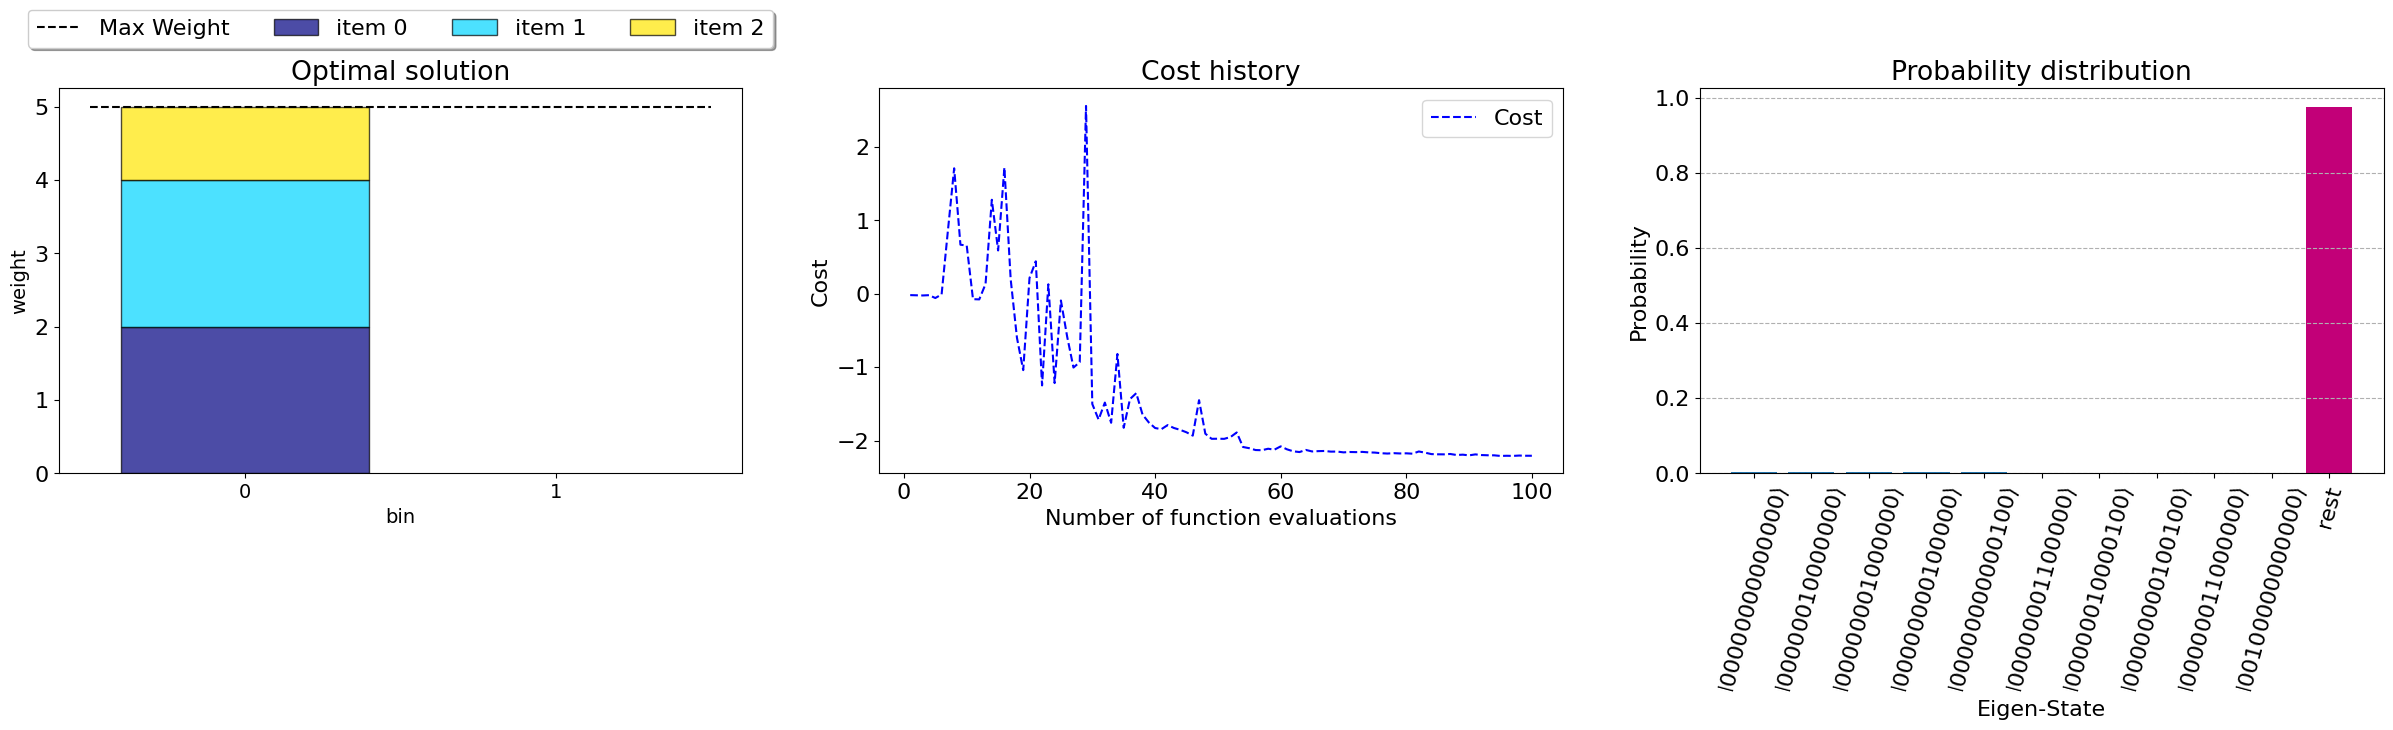

In [8]:
fig, ax = plt.subplots(1,3, figsize=(30,5))
_, _ = bpp_slack.plot_solution(results["solutions_bitstrings"][0], ax=ax[0])
_, _ = results_slack.result.plot_cost(ax=ax[1])
_, _ = results_slack.result.plot_probabilities(n_states_to_keep=nstates, ax=ax[2])
t = ax[0].set_title("Optimal solution")

### 2 - Solve using unbalanced penalization

For the penalty terms, we can use the tuned parameters presented in the original [unbalanced penalization paper](https://arxiv.org/abs/2211.13914)

In [ ]:
penalty = [10, 2, 1] # [Equality, Inequality] constraints got from the unbalanced penalization paper
bpp_unbalanced = BinPacking(weights, weight_capacity, n_bins=n_bins, penalty=penalty, simplifications=False, method="unbalanced")
qubo = bpp_unbalanced.qubo # Ising Hamiltonian of the BPP using the slack variables encoding 
results_unbalanced = qaoa_result(qubo, p=5, maxiter=100)

Once again let's analywe the results of the QAOA optimization:

In [ ]:
nstates = 20
results = results_unbalanced.result.lowest_cost_bitstrings(nstates)
indx_opt = results["solutions_bitstrings"].index(sol_cplex)
p = 0
for n in range(nstates): # There are multiple optimal solutions, 
    # Let's check which states share the same enegry with the ground state
    if results["bitstrings_energies"][n] == results["bitstrings_energies"][0]:
        p += results["probabilities"][n]
print(f"The probability of finding the optimal solution using unbalanced penalization is: {round(100*p,1)}%")

The probability of finding the optimal solution using unbalanced penalization is: 12.0%


states kept: 20


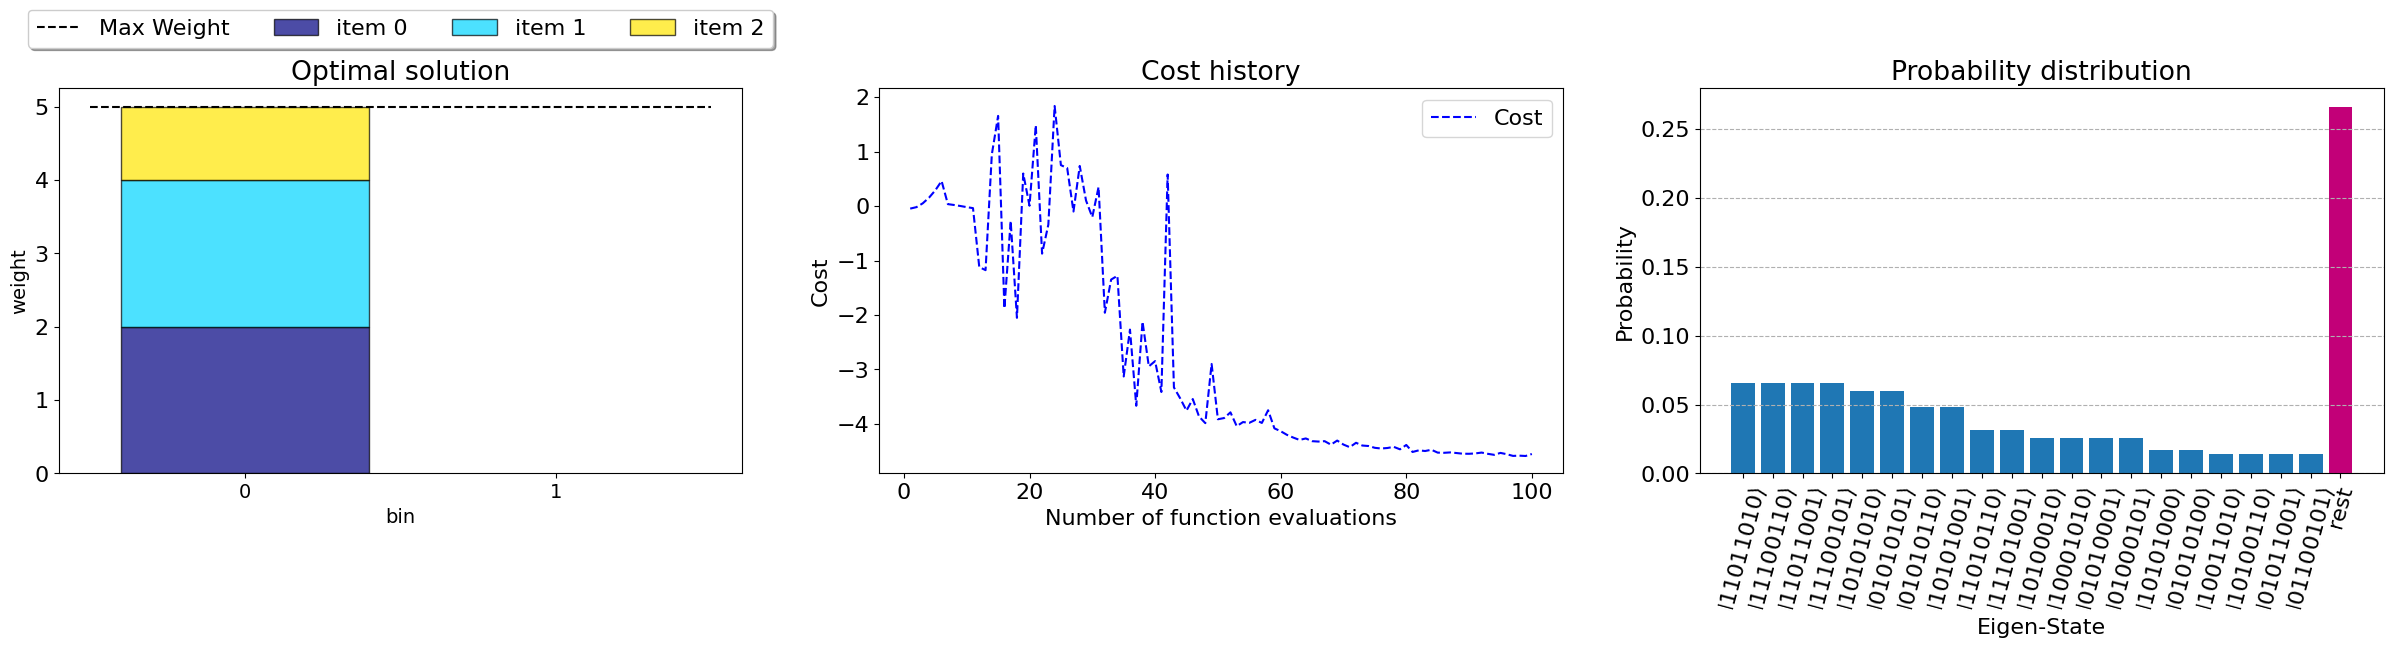

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(30,5))
_, _ = bpp_unbalanced.plot_solution(results["solutions_bitstrings"][0], ax=ax[0])
_, _ = results_unbalanced.result.plot_cost(ax=ax[1])
_, _ = results_unbalanced.result.plot_probabilities(n_states_to_keep=nstates, ax=ax[2])
title=ax[0].set_title("Optimal solution")

# Conclusion 

In this notebook, we tested the BPP using `openqaoa` for a three items problem with QAOA $p=5$. The results are presented for the unbalanced penalization and slack encodings. The unbalanced penalization reduces the number of qubit needed to represent the problems and therefore improves considerably the probability of obtaining the optimal solution compared to the slack variables approach.